# DL4H Project

**Topic:** Combining structured and Unstructured data for Predictive models: A Deep Learning Approach

**Team 105:**
*  Mariano Ovalle (lo22@illinois.edu)
*  Mochammad Dikra Prasetya (mdp9@illinois.edu)
*  Zhang Jiang (zhangj3@illinois.edu)


Link to video presentation:

https://mediaspace.illinois.edu/media/t/1_qmt0onnt



# Introduction

## Objective

Reproducing the "Clinical Fusion" research paper:

> Zhang, D., Yin, C., Zeng, J. et al. Combining structured and unstructured data for predictive models: a deep learning approach. BMC Medical Informatics and Decision Making, 280 (2020). https://doi.org/10.1186/s12911-020-01297-6



## Background

The widespread use of electronic medical records (EHRs) has opened up new avenues for health care research, enabling the resolution of various medical issues. Machine learning and deep learning methods have gained popularity in the field of medical informatics. However, while many research studies focus on structured data for predictive modeling, they often overlook the valuable information contained in unstructured clinical notes. This oversight may limit the accuracy of prediction models. To address this issue, integrating diverse data types from EHRs using deep learning techniques may enhance the performance of predictive models.


## Paper's Proposal

The research introduces two general-purpose multi-modal neural network architectures to combine sequential unstructured notes with structured data for enhanced representation learning and prediction in patient-level medical data. The models use Doc2Vec [2] document embeddings for clinical note documents, and either convolutional neural networks (Fusion-CNN) or long short-term memory networks (Fusion-LSTM) for sequential clinical notes and temporal signals. The final patient representation is obtained by concatenating these representations and used for making predictions.

The proposed Fusion-CNN and Fusion-LSTM are experimented towards in-hospital mortality prediction, long length of stay prediction, and 30-day readmission prediction on MIMIC-III, of which have shown positive results that the new approaches improve the effectiveness of the tasks.

![fusion-cnn.png](https://camo.githubusercontent.com/5e8da03117089410e20fc85e46138a9c92428243184f5e2c1fc13b5e11d4899d/68747470733a2f2f696d6775722e636f6d2f6e4b68414f724d2e706e67)

![fusion-ltsm.png](https://camo.githubusercontent.com/84168f9e94bcfe582069c3fef295bfea99ab157bdb2fe643503c23e197a1bd68/68747470733a2f2f696d6775722e636f6d2f416772496b6c362e706e67)

# Scope of Reproducibility:

## Hypotheses

There are 2 hypotheses of this paper to be tested:
1. By combining the unstructured data (clinical notes), the overall model performance will be improved and outperform than traditional methods such as Random Forest and Logistic Regression.

2. (Based on the statistics in this paper, this seems not to be the case but still plan to verify) Given the inherent advantage of RNN in processing sequential or temporal data, model Fusion-LSTM shall outperform the model Fusion-CNN.


## Ablations Planned

This paper has ablation studies already. Thus we’re planning to replicate that: with U, T, S denoting the unstructured clinical notes, temporal signals, and static information, we’ll perform the evaluations on the two proposed models in this paper with but with just the value embedding inputs (T+S) and another with just the unstructured input (U). This methodology allows us to dissect the relative importance and added value of each combination of data in enhancing the model's accuracy and reliability.

# Methodology

The full code can be accessed in: https://github.com/dkrprasetya/clinical-fusion/tree/dev, which is forked from the paper author's [repository](https://github.com/onlyzdd/clinical-fusion).

Below are the step-by-step explanations with some excerpts of the code. It is a pre-requisite to follow the "Data" section to prepare the processed data for running `baseline.py` and `main.py` at the later stage.

For the explanation convenience, we assume that the codes are available with the below Google drive mounting scheme:

In [ ]:
# Please goto the following shared folder https://drive.google.com/drive/folders/179K-k1hpAg0dqeeH7zJoE0hUteLTBiyc?usp=drive_link
# Select folder name (CS598-demo) -> Organize -> Add shortcut and add the shortcut to MyDrive folder (or any other folder you like, but need to update the location below)
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Should be expected to see corresponding code & data in following folder after mount
!ls "/content/drive/MyDrive/CS598-demo"

00_define_cohort.py  06_doc2vec.py  data_loader.py  myloss.py	 requirements.txt
01_get_signals.py    baselines5.py  function.py     parse.py	 run_baselines.sh
02_extract_notes.py  baselines.py   imgs	    p_value.py	 utils.py
03_merge_ids.py      ci.py	    lstm.py	    __pycache__
04_statistics.py     cnn.py	    main.py	    py_op.py
05_preprocess.py     data	    models	    README.md


### Environment


The list below includes the necessary packages (with their compatible versions) required for this project. Additionally, if you have not previously done so, you will need to download the stopwords from nltk. Instructions for this can be found here: https://stackoverflow.com/questions/41610543/corpora-stopwords-not-found-when-import-nltk-library.

```
Python 3.6.10
Gensim 3.8.0
NLTK: 3.4.5
Numpy: 1.14.2
Pandas: 0.25.3
Scikit-learn: 0.20.1
Tqdm: 4.42.1
PyTorch: 1.4.0
```

We also provide a YAML dependencies file to create the environment to run the project; the file is in the repository:

https://github.com/dkrprasetya/clinical-fusion/blob/dev/ClinicalFusionEnviroment.yaml

##  Data

### Preprocessing instruction

The raw data used in this project is from the Medical Information Mart for Intensive Care III (MIMIC-III v1.4), available at https://physionet.org/content/mimiciii/1.4/. The tables utilized include ADMISSIONS, CHARTEVENTS, DIAGNOSES_ICD, ICUSTAYS, LABEVENTS, NOTEEVENTS, and PATIENTS. The overall unzipped database size is approximately 6.16 GB. After unzipping, the required tables alone exceed 40 GB in size. Due to this and security issue, only some processed data will be uploaded to Google Drive and mounted to this Colab.

For data processing:

1. Data loading is first performed using PostgreSQL, following the steps outlined at https://github.com/MIT-LCP/mimic-code/tree/main/mimic-iii/buildmimic/postgres. Due to the CHARTEVENTS table being larger than 30 GB, loading it can take between 4-6 hours. We utilize SQL queries (found at 'https://github.com/dkrprasetya/clinical-fusion/tree/dev/sql_query') adm_details.sql, pivoted_lab.sql, and pivoted_vital.sql, derived from the original paper to generate corresponding processed tables. These are then stored as CSV files in `<code_root>/data/mimic` (found at 'https://github.com/dkrprasetya/clinical-fusion/tree/dev/data/mimic'). The adm_details.csv file results from joining the ADMISSIONS and PATIENTS tables with required features. pivoted_lab.csv and pivoted_vital.csv are generated from ADMISSIONS, ICUSTAYS, LABEVENTS, and CHARTEVENTS tables, providing tables of lab test results and vital sign measurements, respectively, based on ICU and hospital stay intervals.

2. We then use data preprocessing code from the original repository to generate processed data (available in 'https://github.com/dkrprasetya/clinical-fusion/tree/dev/data/processed'). It's noted that the original preprocessing code contains minor bugs. For instance, in the latest MIMIC-III release, most timestamps in the ADMISSIONS, ICUSTAYS, and PATIENTS tables are synthetic (post-2100), yet some patient DOBs appear to be real (1800s). When calculating patients' ages at admission (admittime - dob), ages greater than 300 years are outliers and can cause RuntimeError. To mitigate such outliers, we've imposed a limit on the DOB, setting the minimal acceptable DOB to 2100-01-01. Additionally, various minor issues with the original paper were identified and corrected in our updated version. To replicate our results, ensure you have the previously generated adm_details.csv, pivoted_lab.csv, and pivoted_vital.csv, along with the unzipped tables of MIMIC-III (ADMISSIONS.csv, CHARTEVENTS.csv, DIAGNOSES_ICD.csv, ICUSTAYS.csv, LABEVENTS.csv, NOTEEVENTS.csv, and PATIENTS.csv) under the folder 'https://github.com/dkrprasetya/clinical-fusion/tree/dev/data/mimic', then run the following code:

```
$ python 00_define_cohort.py
$ python 01_get_signals.py
$ python 02_extract_notes.py --firstday
$ python 03_merge_ids.py
$ python 04_statistics.py
$ python 05_preprocess.py
$ python 06_doc2vec.py --phase train # train doc2vec model
$ python 06_doc2vec.py --phase infer # infer doc2vec vectors
```




### Data description

We've created overviews for patient demographics, including gender, age, and ethnicity, based on the preprocessed adam_details.csv result.

**Gender Distribution**

The gender distribution in the dataset shows a relatively balanced ratio between male and female patients, with males outnumbering females by a slight margin of 20%.

<img src="https://drive.google.com/uc?id=1NNfgdnqxJXav1_MiWl-eHpvB9FKHxrOr" width="400" height="300" />

**Age Distribution at Admission**

The original adam_details.csv file does not include an age column, so we calculated age using the formula `age = (row['admittime'] - row['dob']).days / 365`. As previously noted, some data in the latest MIMIC-III dataset are synthetic, and we have eliminated outliers with ages over 300 years during processing. Although there remains a significant number of entries (approximately 8,000 data points) indicating ages under one year, these are challenging to categorize definitively as inaccurate because they could represent infants. The age distribution of admitted patients covers a wide range, with a noticeable increase in older age groups. This trend aligns with expectations, as older people typically have a higher risk of requiring hospitalization.

<img src="https://drive.google.com/uc?id=10GGH4gND65-71c2h-nOUfYOKpzZ6Yieo" width="400" height="300" />

**Ethnicity Distribution**

The ethnicity distribution bar graph below displays the diversity of ethnicity columns in original table. The graph indicates that the majority of patients are White, followed by other ethnic groups. This distribution is expected, given that the MIMIC-III dataset collects data from hospitals in the United States, and reflects proportions similar to the overall U.S. population.

<img src="https://drive.google.com/uc?id=1oIP8vjIhzOuIHbxFgIu6n5giCsyQsVRP" width="500" height="400" />


### Preprocessing code

We've also uploaded the preprocessed data through google drive: https://drive.google.com/drive/folders/1M56IW0jcFZCFUjoZNldjYco8hxXqQ81C?usp=drive_link. Note that the preprocessed files are a lot and not recomended to download all to reproduce our results. We suggest to only download the step 1 result: adm_details.csv, pivoted_lab.csv, and pivoted_vital.csv files under `/mimic` folder, and put in local `/data/mimic` folder and run preprocessing python code in step 2.

Expected to have following files under `/data/mimic` before running python preprocessing code in step 2.

![Required files](https://drive.google.com/uc?id=1t283iK4wA0qp1bNxV2O8DOgNQ9XJ4XkL)

In this notebook, due to the constraints of the original data size and training time, we will use the PhysioNet MIMIC-III demo dataset to demonstrate reproducibility, available here: https://physionet.org/content/mimiciii-demo/1.4/. It's important to note that we have replaced the NOTEEVENTS.csv file from the demo dataset with its counterpart from the full MIMIC-III dataset, as the demo version of NOTEEVENTS.csv contains only the column headers and no actual data, making it unsuitable for our purposes.

In [ ]:
# Notebook demo running: Data preprocessing
%cd "/content/drive/MyDrive/CS598-demo"
%ls
# Default colab doesn't contain stopwords from nltk and have to download manually
!python -m nltk.downloader stopwords

!python 00_define_cohort.py
!python 01_get_signals.py
!python 02_extract_notes.py --firstday
!python 03_merge_ids.py
!python 04_statistics.py
!python 05_preprocess.py
!python 06_doc2vec.py --phase train # train doc2vec model
!python 06_doc2vec.py --phase infer # infer doc2vec vectors

/content/drive/.shortcut-targets-by-id/179K-k1hpAg0dqeeH7zJoE0hUteLTBiyc/CS598-demo
00_define_cohort.py  06_doc2vec.py  data_loader.py  myloss.py     requirements.txt
01_get_signals.py    baselines5.py  function.py     parse.py      run_baselines.sh
02_extract_notes.py  baselines.py   imgs/           p_value.py    utils.py
03_merge_ids.py      ci.py          lstm.py         __pycache__/
04_statistics.py     cnn.py         main.py         py_op.py
05_preprocess.py     data/          models/         README.md
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Total admissions: 129
After removing non-adults: 109
After removing less than 1 day: 100
Processing patients demographics...
Done.
Reading 

##   Model

In this project there're multiple models, including the Doc2Vec model from `gensim.models.doc2vec` and two models implemented with PyTorch (from the original repository): LSTM and CNN.

LSTM ('https://github.com/dkrprasetya/clinical-fusion/blob/dev/lstm.py'): This model leverages document embeddings, a BiLSTM layer, and a max-pooling layer to process sequential clinical notes. Two LSTM layers (imported from `torch.nn.LSTM`) are employed for processing data, with the first layer dedicated to unstructured text data and the second layer to structured clinical event sequences. The model utilizes adaptive max pooling to compact the sequence representation into a fixed-size vector. Furthermore, several linear and nonlinear mappings (with ReLU and Dropout) transform the embeddings and LSTM outputs into feature spaces suitable for final prediction data structure.

CNN ('https://github.com/dkrprasetya/clinical-fusion/blob/dev/cnn.py'): The CNN model also uses document embeddings and employs a 2-layer CNN architecture followed by max-pooling to process sequential clinical notes. The convolutional layers are designed to capture patterns in the data, with the max-pooling layer reducing the dimensionality of the output for subsequent layers. The CNN architecture is further enhanced with residual blocks to facilitate deeper learning without the vanishing gradient problem. Also, each block of this CNN model includes convolutional layers with ReLU activation and Batch Normalization(`nn.BatchNorm1d`).

The loss function is also defined by a separate file 'https://github.com/dkrprasetya/clinical-fusion/blob/dev/myloss.py'. In short,
the Loss class implements binary cross-entropy loss (nn.BCELoss) after applying a sigmoid activation (nn.Sigmoid) to the model's outputs.

As for optimizer: Adam optimizer (imported from `torch.optim.Adam`) is used for adjusting the weights of the network, with the learning rate potentially modified dynamically across training epochs to fine-tune the training process.


The models are not pretrained.

```
import lstm, cnn
import parse

# Pending update to accommendate in this notebook
args = parse.args

#model = cnn.CNN(args)
model = lstm.LSTM(args)

loss_func = None
optimizer = None

# def train_model_one_iter(model, loss_func, optimizer):
#   pass

# num_epoch = 10
# # model training loop: it is better to print the training/validation losses during the training
# for i in range(num_epoch):
#   train_model_one_iter(model, loss_func, optimizer)
#   train_loss, valid_loss = None, None
#   print("Train Loss: %.2f, Validation Loss: %.2f" % (train_loss, valid_loss))
```

## Training and Evaluation

We use the function `train_eval` in `main.py` for training and evaluation by setting the argument `phase` to `train` or `test` respectively.

This function also needs the following arguments:


`data_loader:` data for training or evaluation.

`net:` The model type,  can be either an instance of LSTM or CNN, as described above.

`loss:` Loss function instance, (nn.BCELoss)

`epoch:` Number of full cycles through the training data
optimizer: In this case, an instance of an Adam optimizer.


The following code block from `main()` method prepares the instance arguments for function `train_eval`:

```
def main():
    data_splits = json.load(open(os.path.join(args.files_dir, 'splits.json'), 'r'))
    train_files = [f for idx in [0, 1, 2, 3, 4, 5, 6] for f in data_splits[idx]]
    valid_files = [f for idx in [7] for f in data_splits[idx]]
    test_files = [f for idx in [8, 9] for f in data_splits[idx]]
    if args.phase == 'test':
        train_phase, valid_phase, test_phase, train_shuffle = 'test', 'test', 'test', False
    else:
        train_phase, valid_phase, test_phase, train_shuffle = 'train', 'valid', 'test', True
    train_dataset = data_loader.DataBowl(args, train_files, phase=train_phase)
    valid_dataset = data_loader.DataBowl(args, valid_files, phase=valid_phase)
    test_dataset = data_loader.DataBowl(args, test_files, phase=test_phase)
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=train_shuffle, num_workers=args.workers, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, pin_memory=True)

    # net = icnn.CNN(args)

    if args.model == 'cnn':
        net = cnn.CNN(args)
    else:
        net = lstm.LSTM(args)
    # net = torch.nn.DataParallel(net)
    # loss = myloss.Loss(0)
    loss = myloss.MultiClassLoss(0)

    net = _cuda(net, 0)
    loss = _cuda(loss, 0)

    best_metric= [0,0]
    start_epoch = 0

    if args.resume:
        p_dict = {'model': net}
        # function.load_model(p_dict, args.resume)
        net.load_state_dict(torch.load('./models/{}.model'.format(args.model)))

    parameters_all = []
    for p in net.parameters():
        parameters_all.append(p)

    optimizer = torch.optim.Adam(parameters_all, args.lr)
```

In case of training the loop calls the `train_eval` function repeatedly according to the `epoch` argument:

```
    if args.phase == 'train':
        for epoch in range(start_epoch, args.epochs):
            print('start epoch :', epoch)
            t0 = time.time()
            train_eval(train_loader, net, loss, epoch, optimizer, best_metric)
            t1 = time.time()
            print('Running time:', t1 - t0)
            best_metric = train_eval(valid_loader, net, loss, epoch, optimizer, best_metric, phase='valid')
        print('best metric', best_metric)
```

```
def train_eval(data_loader, net, loss, epoch, optimizer, best_metric, phase='train'):
    print(phase)
    lr = get_lr(epoch)
    if phase == 'train':
        net.train()
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    else:
        net.eval()

    loss_list, pred_list, label_list, = [], [], []
    for b, data_list in enumerate(tqdm(data_loader)):
        data, dtime, demo, content, label, files = data_list
        if args.value_embedding == 'no':
            data = Variable(_cuda(data))
        else:
            data = index_value(data)


        dtime = Variable(_cuda(dtime))
        demo = Variable(_cuda(demo))
        content = Variable(_cuda(content))
        label = Variable(_cuda(label))
        output = net(data, dtime, demo, content) # [bs, 1]
        # output = net(data, dtime, demo) # [bs, 1]



        loss_output = loss(output, label)
        pred_list.append(output.data.cpu().numpy())
        loss_list.append(loss_output[0].data.cpu().numpy())
        label_list.append(label.data.cpu().numpy())

        if phase == 'train':
            optimizer.zero_grad()
            loss_output[0].backward()
            optimizer.step()
```

Otherwise, model evaluation is executed:

```
elif args.phase == 'test':
    train_eval(test_loader, net, loss, 0, optimizer, best_metric, 'test')
```

In order to train the models we will use the following command:

```
$ python main.py --model [model] --task [task] --inputs [input]
```

In [ ]:
# Notebook demo running: Model training
!python main.py --model lstm --task mortality --inputs 7


Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data
start epoch : 0
train
100% 1/1 [00:02<00:00,  2.83s/it]
1 (0.3137254901960784, 0.49019607843137253, 0.23606538521841486)
Avg [0.3137254901960784, 0.49019607843137253, 0.23606538521841486]

train Epoch 0 (lr 0.010000)
loss: 0.6970 	
Running time: 2.840540647506714
valid
100% 1/1 [00:00<00:00,  1.63it/s]
1 (0.6666666666666665, 0.7916666666666667, 0.6458333333333333)
Avg [0.6666666666666665, 0.7916666666666667, 0.6458333333333333]

valid Epoch 0 (lr 0.010000)
loss: 1.1141 	
				 best epoch: 0     best AUC: 0.7917 	
start epoch : 1
train
100% 1/1 [00:02<00:00,  2.76s/it]
1 (0.40816326530612246, 0.6792717086834733, 0.43254311925330535)
Avg [0.40816326530612246, 0.6792717086834733, 0.43254311925330535]

train Epoch 1 (lr 0.010000)
loss: 1.1718 	
Running time: 2.7655723094940186
valid
100% 1/1 [00:00<00:00,  1.44it/s]
1 (0.6, 0.625, 0.6178571428571429)
Avg [0.6, 0.625, 0.6178571428571429]

valid

Where:

`[model]` Options:  `cnn` or `lstm`

`[task]` Options: `mortality`, `readmit`, or `llos`

`[inputs]` Options: `3`: For Temporal Signals + Structure Data, `4`: For Unstructured Data, For `7`: All three combined

For testing the model we will use the same command but setting the flag `phase` to test:
```
$ python main.py --model [model] --task [task] --inputs [input] --phase test
```

In [ ]:
# Notebook demo running: Model testing
# Note that the MIMIC-III demo database is considerably smaller, which means the model may not have enough data and appears to be overfitted.
# Consequently, the results are not as robust as those obtained with the full dataset.
!python main.py --model lstm --task mortality --inputs 7 --phase test

Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data
test
100% 1/1 [00:00<00:00,  1.44it/s]
1 (0.0, 0.26666666666666666, 0.19533991228070174)
Avg [0.0, 0.26666666666666666, 0.19533991228070174]

test Epoch 0 (lr 0.010000)
loss: 0.7018 	
				 best epoch: 0     best AUC: 0.0000 	


## Model comparison


For model performance, the paper code uses `sklearn.metrics` module:

[`metrics.average_precision_score`]( https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)

[`metrics.f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)

[`metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)

```
def cal_metric(y_true, probs):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, probs)
    optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
    optimal_threshold = thresholds[optimal_idx]
    preds = (probs > optimal_threshold).astype(int)
    auc = metrics.roc_auc_score(y_true, probs)
    auprc = metrics.average_precision_score(y_true, probs)
    f1 = metrics.f1_score(y_true, preds)
    return f1, auc, auprc
```

The model performance will be evaluated againts two baseline models: [Logistic Regresion](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) & [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html),  code uses `sklearn.linear_model` module implementation:

```
def train_test_base(X_train, X_test, y_train, y_test, name):
    mtl = 1 if y_test.shape[1] > 1 else 0 # multi-label
    if name == 'lr':
        print('Start training Logistic Regression:')
        model = LogisticRegression()
        param_grid = {
            'penalty': ['l1', 'l2']
        }
    else:
        print('Start training Random Forest:')
        model = RandomForestClassifier()
        param_grid = {
            'n_estimators': [x for x in range(20, 40, 5)],
            'max_depth': [None, 20, 40, 60, 80, 100]
        }
    if mtl:
        model = OneVsRestClassifier(model)
    else:
        y_train, y_test = y_train[:, 0], y_test[:, 0]
    t0 = time.time()
    gridsearch = GridSearchCV(model, param_grid, scoring='roc_auc', cv=5)
    gridsearch.fit(X_train, y_train)
    model = gridsearch.best_estimator_
    t1 = time.time()
    print('Running time:', t1 - t0)
    probs = model.predict_proba(X_test)
    metrics = []
    if mtl:
        for idx in range(y_test.shape[1]):
            metric = cal_metric(y_test[:, idx], probs[:, idx])
            print(idx + 1, metric)
            metrics.append(metric)
        print('Avg', np.mean(metrics, axis=0).tolist())
    else:
        metric = cal_metric(y_test, probs[:, 1])
        print(metric)
```

Baselines are generated using the following command (arguments are identical with `main.py`):

```
$ python baselines.py --model [model] --task [task] --inputs [inputs]
```

In [ ]:
#  Notebook demo running: Baseline verification
!python baselines.py --task mortality --inputs 7 --model all

Running task mortality using inputs 7...
Loading notes...
Loading temporal data...
Loading demographics...
Done.
Start training Logistic Regression:
Running time: 0.5498065948486328
(0.16666666666666666, 0.3666666666666667, 0.27485380116959063)
Start training Random Forest:
Running time: 7.559025287628174
(0.25, 0.48333333333333334, 0.30753968253968256)


# Results

We implemented corrections in the code and were able to run it using the implementation intended by the paper's authors. Deep Learning models use Pytorch with an Adam optimizer, ReLU activation functions, and a learning rate of 0.0001. Considering the number of models to be trained for the different ablations, we decided to use 25 epochs instead of the 50 proposed by the authors; in two cases, we later used 50 to better match our results with those on the paper. Data is separated into 3 sets for training, verification, and testing at a rate of 70%, 10%, and 20%, respectively. The primary evaluation metric is AUROC; the F1 score and AUPRC are also provided. Most models were trained and tested on a Mac Computer with 3.4 GHz Quad-Core Intel Core i5 Processor and 24 GB 2400 MHz DDR4 of RAM, training and testing times for each model / epoch can be found in https://github.com/dkrprasetya/clinical-fusion/tree/dev/models



The following tables show the results of the different models:




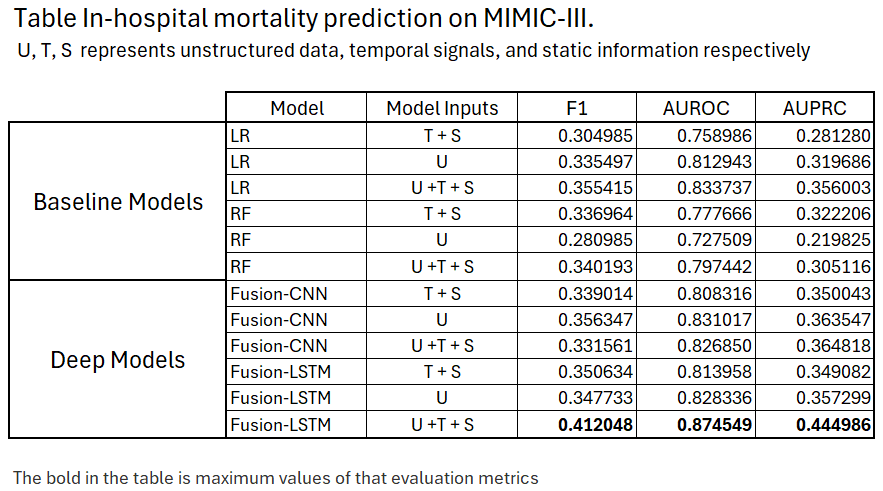

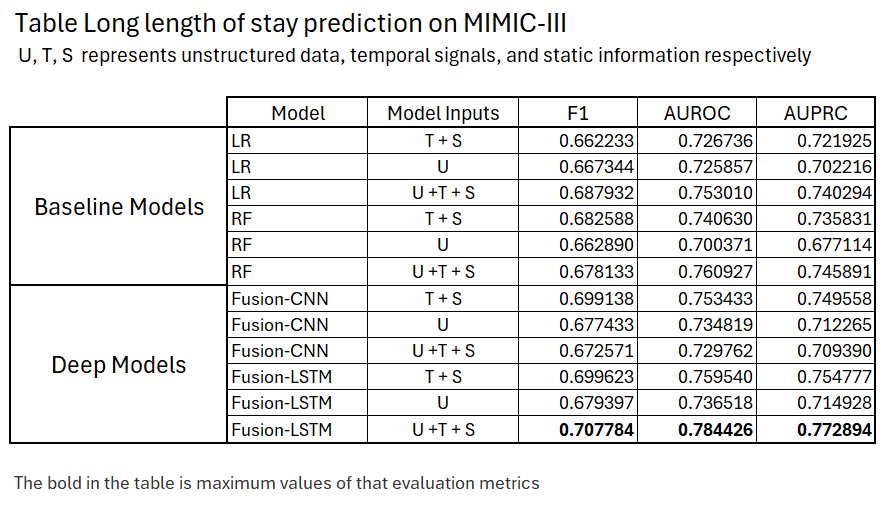

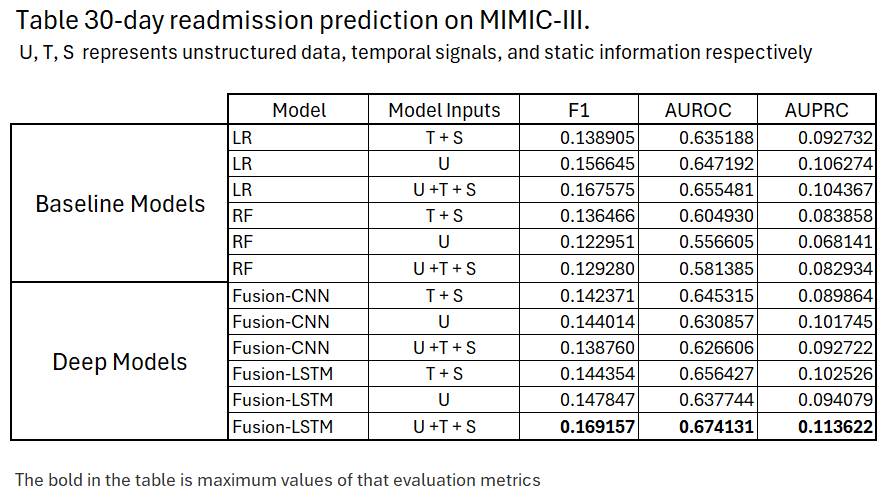

Significantly, we observed that, in some cases, in the paper's results, the Fusion-CNN model outperforms the Fusion-LSTM; however, in our testing, this is not the case, as the Fusion-LSTM consistently gives the better score. To investigate this, we made the decision to retrain the Fusion-CNN with 50 epochs, aiming to verify if we could get closer to the papers' results. The results are the following:

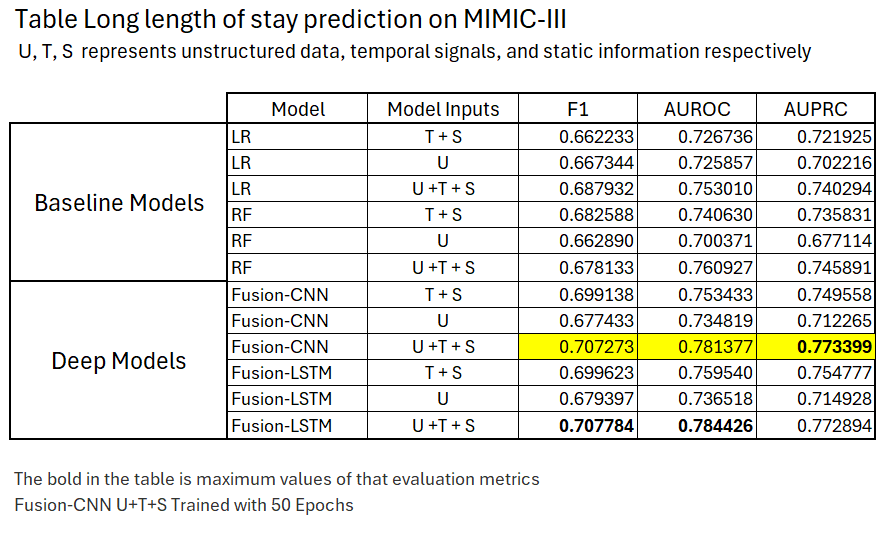

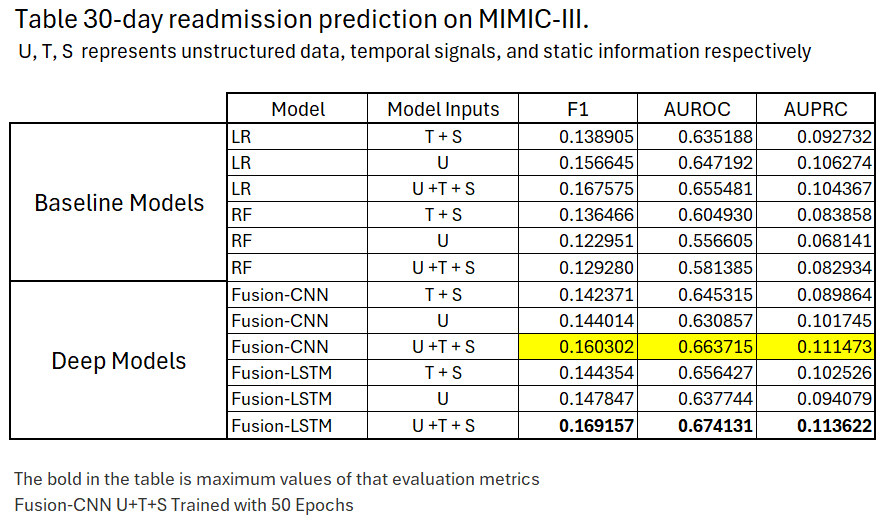

The results with 50 epochs show that the Fusion-CNN scores are much closer now and, in some cases, outperform those of the Fusion-LSTM, confirming the paper's results. Apparently, the CNN neural network needs more iterations to guarentee optimal weights.

Note that the time required to train and test all 27 models is significant and cannot be completed in a reasonable time in this Notebook; we ran all the calculations on our local computers, saved the train and test outputs, and all model checkpoints for future reference. The files can be found in our repository in the following folder:

https://github.com/dkrprasetya/clinical-fusion/tree/dev/models

# Discussion

## Discoveries

### Implications of the experimental results

We managed to reproduce the original paper after patching minor fixes to the code provided by the original paper.

We confirmed the hypotheses that:

1. We confirmed the hypothesis that combining all the data (sequential notes, temporal signals, and demographics)  with deep models outperforms the traditional baseline models; in all cases, the deep models made better classifications than the baseline models. Additionally, ablations show that sequential notes significantly impact the model's performance; the prediction performance scores between models using U+T+S against T+S confirm this asseveration.

2. We confirmed that Fusion-LSTM outperforms Fusion-CNN in all cases.

whether the original paper was reproducible, and if it wasn’t, what factors made it irreproducible"

1. The original source code is not runnable at the get go. Some fixes were necessary to successfully run the entire flow (data processing -> train -> test).

2. Some parameters were missing in the code (e.g., how many layers, how many iterations), so investigating which parameters were used in the paper was necessary.

3. The training step is currently running at 10 mins **per epoch**. We might need to improve / find solution for faster run.

4. In general, we feel the paper is likely reproducible. Although, we will need more iteration to confirm whether currently things are running correctly.

### What was easy

1. The dataset employed in this study is MIMIC-III, which is widely recognized and accessible.

2. Most of the code from the original author's GitHub repository runs smoothly with the latest versions of the required packages. We encountered few issues (and some warnings) but the code does not rely heavily on deprecated dependencies.

### What was difficult

1. MIMIC-III is a substantial database, and preprocessing its data is a time-intensive task. This study requires processing the data using SQL, necessitating the loading of the entire dataset, or at least its largest tables, into a PostgreSQL database to execute the SQL queries.

2. The original paper does not specify which version of MIMIC-III was used. It is clear that there have been changes in the data and its structure compared to the version utilized by the original authors. Consequently, we will need to adapt the original code and incorporate additional preprocessing steps to accommodate these changes.


3. The MIMIC-III dataset is too voluminous to be accommodated by Colab. Therefore, to ensure this notebook functions, we are considering the use of the MIMIC-III demo dataset. However, some data structures, such as column names in certain tables, differ between the demo and the real MIMIC-III datasets, and we have to make separate updates to the preprocessing code. Additionally, a key input file, NOTEEVENTS.csv, is empty in the demo dataset. We must use the actual data from this table to enable the demo to function properly.


4. Setting up the environment and getting the code to execute were the two hurdles in this project; using a non-Unix-like OS also caused issues for some team members due to path syntax used in preprocessing functions.


5. After running the full models, ablations configuration also took some time to understand as it was not evident what input data was being used for training and how the neural network configuration changed according to the options selected; at some point, we needed to retrain some of the models once we understood this part.


6. The time required to train and test all models and ablations is extensive.


### Recommendations for reproducibility

1. We strongly recommend reproducing this project on a Mac or Unix system rather than Windows. This is due to differences in file path syntax and naming conventions between Windows and Mac/Unix systems, which can lead to numerous errors and exceptions when running the code.

2. Data preprocessing with SQL from the MIMIC-III CSV files (data preprocessing step 1) can be time-consuming. Some tables may exceed 30 GB, and merely loading them can take between 4-6 hours. Ensure that your laptop is set not to enter sleep mode automatically during this lengthy preprocessing phase.

3. Using Anaconda and the provided YAML file facilitates the creation of the environment necessary to execute the project.


# References

1.   Zhang, D., Yin, C., Zeng, J. et al. Combining structured and unstructured data for predictive models: a deep learning approach. BMC Med Inform Decis Mak 20, 280 (2020). https://doi.org/10.1186/s12911-020-01297-6

2. Le Q, Mikolov T. Distributed representations of sentences and documents. In: International conference on machine learning (2014). p. 1188–1196.

